In [1]:
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from scipy import stats

from skimage import io
from skimage.util import img_as_ubyte
from skimage.exposure import histogram
from skimage.filters import sobel
from skimage.morphology import watershed
from skimage.feature import canny
from skimage.draw import circle

In [2]:
img_dir = "/Users/gonzalovidal/Gonzalo/Synthetic Biology/Corchea/Fluts_C1" # Enter Directory of all images in the first position
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort()
data = []
for f1 in files:
    imraw = io.imread(f1)
    data.append(imraw)
np_data = np.array(data)
np_data.shape

(859, 720, 960, 3)

#### Select  mask parameters

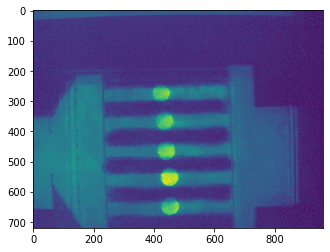

In [3]:
mask_channel = 1
mask_time = 20
im = np_data[mask_time,:,:,mask_channel]
#Obtain the channel as ubyte
image = img_as_ubyte(im)
plt.imshow(image)

#### MASK Segmentation algorithm

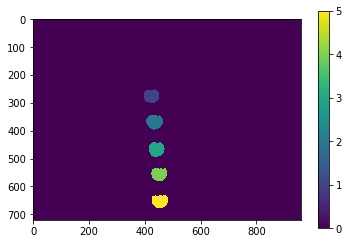

In [4]:
hist, hist_centers = histogram(im)
edges = canny(im/255.)
fill_im = ndi.binary_fill_holes(edges) 
label_objects, nb_labels = ndi.label(edges)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 1
mask_sizes[0] = 0
im_cleaned = mask_sizes[label_objects]
markers = np.zeros_like(im)
markers[im < 30] = 1
markers[im > 50] = 2
elevation_map = sobel(im)
markers = np.zeros_like(im) 
markers[im < 30] = 1
markers[im > 50] = 2
segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_discs, _ = ndi.label(segmentation)
plt.imshow(labeled_discs)
plt.colorbar()

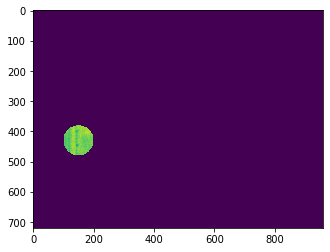

In [5]:
bgcircle = np.zeros((image.shape), dtype=np.uint8)
rr, cc = circle(430, 150, 50) #X, Y, r
bgcircle[rr, cc] = 1
areabg = np.sum(bgcircle)
plt.imshow(bgcircle*np_data[1,:,:,1])

#### Extract data

In [6]:
columns = {'Time':[],'Sample':[],'Value':[],'Name':[]}
Corchea_df = pd.DataFrame(columns)
time = np_data.shape[0]
Corchea_df

,Time,Sample,Value,Name


In [7]:
for t in range(time):   
    for disc in range(1,6): #the complement is the disc 0
        sample = labeled_discs==disc
        area = np.sum(sample)#quit this from for loop and put calculate only 1 time
        rbgfluo = np.sum(bgcircle*np_data[t,:,:,0])
        ravbgfluo = rbgfluo/areabg
        gbgfluo = np.sum(bgcircle*np_data[t,:,:,1])
        gavbgfluo = gbgfluo/areabg
        rfluo = np.sum(sample*np_data[t,:,:,0])
        ravfluo = (rfluo/area)-ravbgfluo
        gfluo = np.sum(sample*np_data[t,:,:,1])
        gavfluo = (gfluo/area)-gavbgfluo
        
        d_fluo_av_r = {'Time':t,'Sample':disc,'Value':ravfluo,'Name':'RFP'}
        pd_fluo_av_r = pd.DataFrame([d_fluo_av_r])
        d_fluo_av_g = {'Time':t,'Sample':disc,'Value':gavfluo,'Name':'GFP'}
        pd_fluo_av_g = pd.DataFrame([d_fluo_av_g])
        
        Corchea_df = Corchea_df.append(pd_fluo_av_r,ignore_index=True )
        Corchea_df = Corchea_df.append(pd_fluo_av_g,ignore_index=True )
Corchea_df

,Time,Sample,Value,Name
0,0.0,1.0,35.213816,RFP
1,0.0,1.0,17.774282,GFP
2,0.0,2.0,32.257839,RFP
3,0.0,2.0,15.413306,GFP
4,0.0,3.0,61.599830,RFP
...,...,...,...,...
8585,858.0,3.0,14.594870,GFP
8586,858.0,4.0,107.343471,RFP
8587,858.0,4.0,20.669944,GFP
8588,858.0,5.0,137.983746,RFP


#### Plots

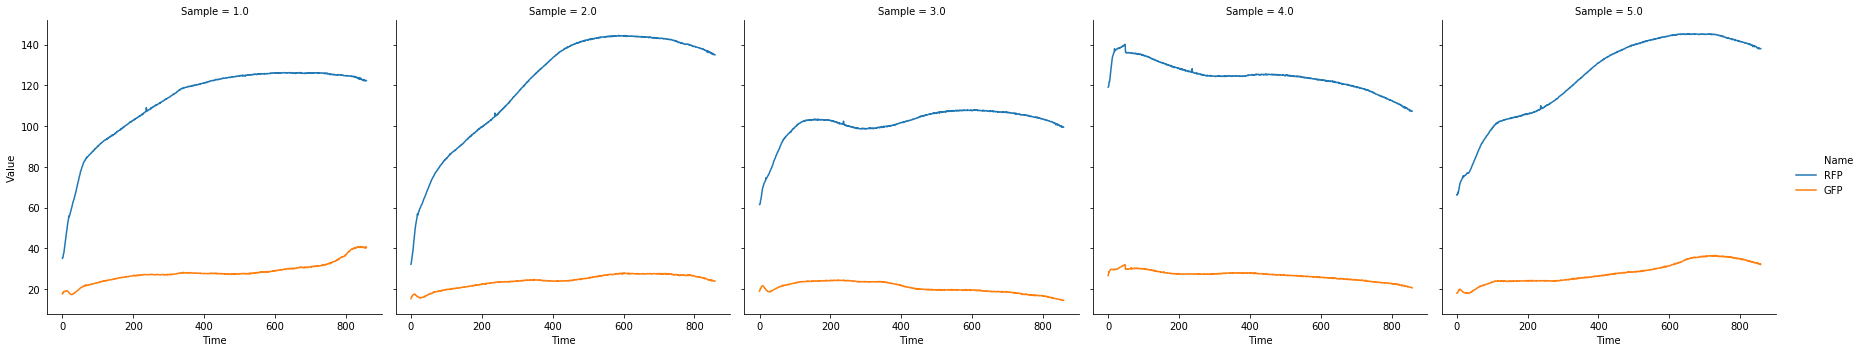

In [8]:
sns.relplot(x="Time", y="Value",
            hue="Name", col="Sample",
            kind="line", data=Corchea_df); #, col="Sample"
#plt.ylim([0,30])

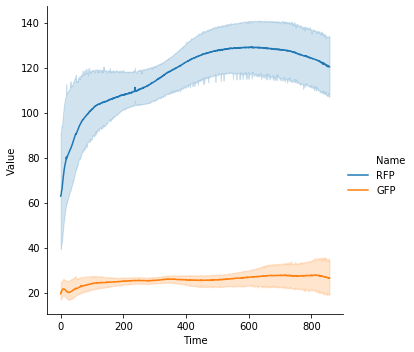

In [9]:
sns.relplot(x="Time", y="Value",
            hue="Name", 
            kind="line", data=Corchea_df);

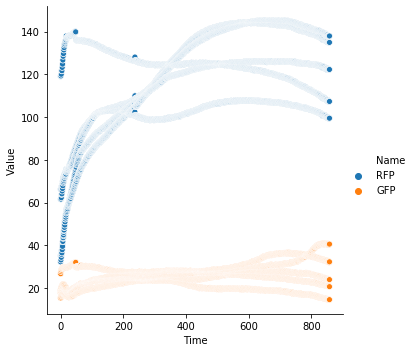

In [10]:
sns.relplot(x="Time", y="Value",
            hue="Name", 
            kind="scatter", data=Corchea_df);

#### Not all Corchea experiments work at the first try, keep trying and learn!